[View in Colaboratory](https://colab.research.google.com/github/silentvoice/dl-with-keras/blob/master/neural-style-transfer.ipynb)

# Neural Style Transfer

In [0]:
# this resets the state of the machine (e.g. if you want to re-install from scratch  # this  
# or reset memory usage in this instance)
# wait a minute after running it and then reload the page
#!kill -9 -1

## Check Tensorflow Version

In [0]:
import tensorflow as tf

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
tf.__version__

'1.9.0'

## Imports

In [0]:
from tensorflow import keras
from tensorflow.python.keras.applications import vgg19
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

## Import Content and Style Image

In [6]:
from google.colab import files
files.upload()

Saving content.jpg to content.jpg


{'content.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x10\x0b\x0c\x0e\x0c\n\x10\x0e\r\x0e\x12\x11\x10\x13\x18(\x1a\x18\x16\x16\x181#%\x1d(:3=<9387@H\\N@DWE78PmQW_bghg>Mqypdx\\egc\xff\xdb\x00C\x01\x11\x12\x12\x18\x15\x18/\x1a\x1a/cB8Bcccccccccccccccccccccccccccccccccccccccccccccccccc\xff\xc0\x00\x11\x08\x03\xe8\x05m\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe

In [7]:
from google.colab import files
files.upload()

Saving style.jpeg to style.jpeg


{'style.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x13\x13\x12\x15\x13\x13\x13\x16\x16\x15\x16\x18\x16\x18\x18\x17\x18\x17\x1f\x18 \x19\x1d\x18\x17\x17\x18\x17\x1d\x1d\x19\x18\x1d( \x1b\x1d%\x1d\x17\x17!1"%)+...\x18\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1b\x10\x10\x1b2% %-/--/0/--/---------------/---------/------/-----/-\xff\xc0\x00\x11\x08\x00\xb7\x01\x13\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x03\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x05\x02\x01\x06\x00\x07\x08\xff\xc4\x00?\x10\x00\x01\x02\x04\x04\x03\x05\x07\x03\x02\x05\x03\x05\x00\x00\x00\x01\x02\x11\x00\x03!1\x04\x12AQ\x05aq\x13"\x81\x91\xa1\x062B\xb1\xc1\xd1\xf0Rb\xe1\x14\x82#3Cr\xf1\x15S\x92$s\xa2\xc2\xd2\xff\xc4\x00\x1c\x01\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x01\x02\x05\x00\x06\x07\x08\xff\xc4\x00>\x11\x00\x01\x02\x04\x04\x03\x06\x05\x03\x04\x01\x03\x04\x03\x00\x00\x01\x02\x03\x00\

In [0]:
content_img_path = '/content/content.jpg'
style_img_path = '/content/style.jpeg'

In [0]:
width, height = load_img(content_img_path).size

In [11]:
width, height

(1389, 1000)

In [0]:
img_height = 400
img_width = int(width * img_height / height)

## Utility Functions for Image Preprocessing

In [0]:
def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_image(x):
    # Reverse Transform vgg19.preprocess_input
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Data Preprocessing

In [0]:
content_img = K.constant(preprocess_image(content_img_path))
style_img = K.constant(preprocess_image(style_img_path))

In [0]:
generated_img = K.placeholder((1, img_height, img_width, 3))

In [0]:
input_tensor = K.concatenate([content_img, style_img, generated_img], axis=0)

## Instantiate the VGG19 Model

In [20]:
model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 19s 0us/step


## Define Loss

In [0]:
def content_loss(content, generated):
  return K.sum(K.square(generated - content))

In [0]:
def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0 , 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

In [0]:
def style_loss(style, generated):
  S = gram_matrix(style)
  C = gram_matrix(generated)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C))/ 4. * (channels ** 2) * (size ** 2)

In [0]:
def regularization_loss(x):
  a = K.square(
      x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
  b = K.square(
      x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

regularization_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
content_img_features = layer_features[0, :, :, :]
generated_img_features = layer_features[2, :, :, :]

loss = loss + content_weight * content_loss(content_img_features, generated_img_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_img_features = layer_features[1, :, :, :]
    generated_img_features = layer_features[2, :, :, :]
    sl = style_loss(style_img_features, generated_img_features)
    loss = loss + (style_weight / len(style_layers)) * sl
    
loss = loss + regularization_weight* regularization_loss(generated_img)

## Minimize Loss

In [0]:
grads = K.gradients(loss, generated_img)[0]

get_loss_grads = K.function([generated_img], [loss, grads])

In [0]:
class Evaluator(object):

    def __init__(self):
        self.loss_val = None
        self.grads_vals = None

    def loss(self, x):
        assert self.loss_val is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = get_loss_grads([x])
        loss_val = outs[0]
        grad_vals = outs[1].flatten().astype('float64')
        self.loss_val = loss_val
        self.grad_vals = grad_vals
        return self.loss_val

    def grads(self, x):
        assert self.loss_val is not None
        grad_vals = np.copy(self.grad_vals)
        self.loss_val = None
        self.grad_vals = None
        return grad_vals

evaluator = Evaluator()

In [40]:
iterations = 20

x = preprocess_image(content_img_path)
x = x.flatten()
for i in range(iterations):
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    end_time = time.time()
    print(i, (end_time - start_time), min_val)

0 18.9951331615448 1.484244e+33
1 18.80978775024414 7.3450735e+32
2 19.050692558288574 4.9090903e+32
3 18.923537492752075 3.9123787e+32
4 19.05940008163452 3.3272316e+32
5 19.103259801864624 2.9342189e+32
6 19.029221296310425 2.6948606e+32
7 19.0632381439209 2.477113e+32
8 19.089620113372803 2.2977277e+32
9 18.971441984176636 2.1752276e+32
10 19.01052761077881 2.075579e+32
11 19.0989191532135 1.9805598e+32
12 19.187782764434814 1.8824151e+32
13 18.951366186141968 1.8162838e+32
14 19.219057321548462 1.7527254e+32
15 19.104767322540283 1.7003122e+32
16 19.13788151741028 1.6465517e+32
17 19.110769987106323 1.5993287e+32
18 19.166351318359375 1.5453681e+32
19 18.976539850234985 1.5010745e+32


In [0]:
img = x.copy().reshape((img_height, img_width, 3))
img = deprocess_image(img)

## Show Content, Style and Generated Image

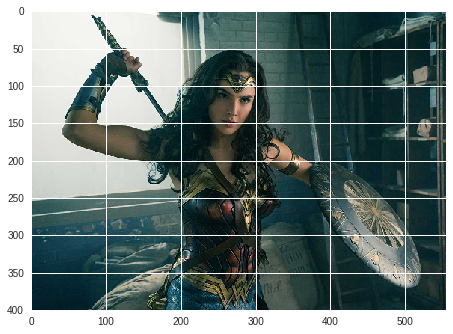

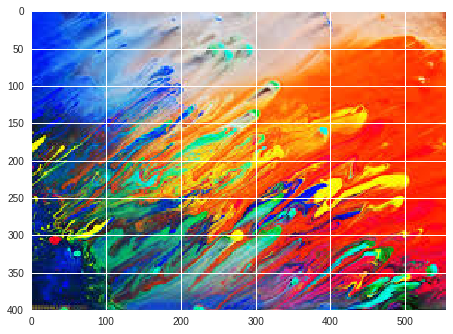

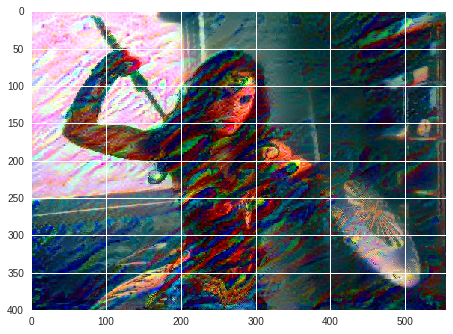

In [41]:
from matplotlib import pyplot as plt

plt.imshow(load_img(content_img_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(load_img(style_img_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(img)